# Jacobo Casado de Gracia 
Apartado de análisis, evaluación y reentrenamiento del mejor modelo. \\
Desarrollado en Google Colab.

# Importación de librerías necesarias para el proyecto.

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.applications.efficientnet import *
from sklearn.model_selection import StratifiedKFold

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Funciones ya comentadas en el otro script llamado train_test_val_creation y que se adjuntan y utilizan aquí. \\
Se podría utilizar un dataframe de un fichero pero se cargan los datos de nuevo debido a que el proceso de entrenamiento es más rápido así. \\
Si se desea más información acerca de las funciones, recomiendo consultar el fichero comentado anteriormente donde se explica lo que realiza cada una de ellas.

In [ ]:
def get_dataframe(sdir, dir):

    ht  = 0
    wt = 0
    samples = 0
    sample_count = 10
    filepaths = []
    labels = []
    classlist = os.listdir(sdir)


    for klass in classlist:

        classpath = os.path.join(sdir, klass)
        flist = os.listdir(classpath)

        for i, f in enumerate(flist):

            fpath=os.path.join(classpath,f)

            try: 
                img = plt.imread(fpath)
                shape = img.shape
                filepaths.append(fpath)
                labels.append(klass)  


                if i < sample_count:
                    img = plt.imread(fpath)               
                    ht += img.shape[0]
                    wt += img.shape[1]
                    samples += 1
            except:
                print ('El archivo ', fpath, ' es una imagen inválida. ')

    filepaths = pd.Series(filepaths, name='filepaths')
    labels = pd.Series(labels, name='labels')

    df = pd.concat([filepaths, labels], axis = 1)
    class_count = len(df['labels'].unique())
    print('El df tiene ', class_count, ' clases.')

    groups = df.groupby('labels')
    print('{0:^30s} {1:^13s}'.format('Clase', 'Cantidad de imágenes'))

    

    for label in df['labels'].unique():
          group = groups.get_group(label)      
          print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

    wave = wt/samples
    have = ht/samples
    aspect_ratio = have/wave
    print ('Altura media: ' ,have, '  Anchura media: ', wave, '  Aspect ratio medio: ', aspect_ratio)
    
    return df

def trim (df, max_size, min_size):
    
    column = 'labels'
    df = df.copy()
    original_class_count = len(list(df[column].unique()))   
    sample_list = [] 
    spare_list = []
    groups = df.groupby(column)
    
    for label in df[column].unique(): 
        
        group = groups.get_group(label)
        sample_count = len(group)    
        
        if sample_count > max_size:
            strat = group[column]
            samples, spare_data = train_test_split(group, train_size = max_size, shuffle = True, random_state = 123, stratify = strat)            
            sample_list.append(samples)
            spare_list.append(spare_data)
            
        elif sample_count >= min_size:
            sample_list.append(group)
            
    df = pd.concat(sample_list, axis = 0).reset_index(drop = True)
    spare_df = pd.concat(spare_list, axis = 0).reset_index(drop = True)
    
    final_class_count = len(list(df[column].unique())) 
    
    if final_class_count != original_class_count:
        print ('El dataframe se ha reducido. Número de clases original: ', original_class_count,' Número de clases actual: ', final_class_count)
        
        
    print("Dataframe trimeado:")
    groups = df.groupby('labels')
    print('{0:^30s} {1:^13s}'.format('Clase', 'Número de imágenes'))
    
    for label in df['labels'].unique():
          group = groups.get_group(label)      
          print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
    
    print("Dataframe spare:")
    groups = spare_df.groupby('labels')
    print('{0:^30s} {1:^13s}'.format('Clase', 'Número de imágenes'))
        
    for label in spare_df['labels'].unique():
      group = groups.get_group(label)      
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

    return df, spare_df

def balance(train_df, max_samples, min_samples, working_dir, image_size, fold_var):
    
    column = 'labels'
    
    train_df = train_df.copy()       

    aug_dir = os.path.join(working_dir, ('aug_fold_' + str(fold_var)))
    
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
        
    os.mkdir(aug_dir)
    
    for label in train_df['labels'].unique():    
        dir_path = os.path.join(aug_dir, label)    
        os.mkdir(dir_path)
        
     
    total = 0
    gen = ImageDataGenerator(rotation_range = 180, width_shift_range = .2, height_shift_range = .2, zoom_range = .1, horizontal_flip=True, vertical_flip = True, brightness_range=[0.7,1.3])
    
    groups=train_df.groupby('labels') # Agrupar por cada clase
    
    for label in train_df['labels'].unique():  # Por cada clase            
        group = groups.get_group(label)  # Nos quedamos con las imágenes de esa clase
        sample_count = len(group)   # Cuántas imágenes hay en esa clase
        if sample_count < max_samples: # Si hay menos imágenes:
            
            aug_img_count = 0
            delta = max_samples-sample_count  # Aumentamos el resto que falta.
            print("Resta de imágenes: ", str(delta))
            target_dir = os.path.join(aug_dir, label)  # Definimos dónde escribir las imágenes.  
            aug_gen = gen.flow_from_dataframe(group,  x_col = 'filepaths', y_col = None, target_size = image_size,
                                            class_mode = None, shuffle = False, 
                                            save_to_dir = target_dir, batch_size = 1, save_prefix = 'aug-', color_mode = 'rgb',
                                            save_format = 'jpg')
            while aug_img_count < delta:
                images = next(aug_gen)            
                aug_img_count += len(images)
                
            total += aug_img_count
            
    print('Imágenes totales creadas debido al aumento de datos:', total)
    
    # Creamos el dataset aumentado y lo unimos al de entrenamiento original.
    if total > 0:
        aug_fpaths = []
        aug_labels = []
        classlist = os.listdir(aug_dir)
        
        for klass in classlist:
            classpath = os.path.join(aug_dir, klass)     
            flist = os.listdir(classpath)    
            
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
                
        Fseries = pd.Series(aug_fpaths, name='filepaths')
        Lseries = pd.Series(aug_labels, name='labels')
        aug_df = pd.concat([Fseries, Lseries], axis = 1)
        train_df = pd.concat([train_df,aug_df], axis = 0).reset_index(drop = True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df

class ASK(keras.callbacks.Callback):
    
    def __init__ (self, model, epochs,  ask_epoch): # Inicializamos el callback
        super(ASK, self).__init__()
        self.model = model               
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True # Al ponerse true pedimos al usuario que introduzca un número de épocas inicial
        
    def on_train_begin(self, logs = None): # Esto se ejecuta al principio del entrenamiento.
        
        if self.ask_epoch == 0: 
            print('Como mínimo se debe de entrenar 1 época, por lo que se entrenará 1.', flush=True)
            self.ask_epoch = 1
            
        if self.ask_epoch >= self.epochs: # Todavía no hay que preguntar
            self.ask=False # No se le pregunta al usuario
            
        if self.epochs == 1:
            self.ask = False # Sólo se ejecuta 1 época. 
            
        else:
            print('El entrenamiento seguirá hasta la época', ask_epoch,'. Posteriormente se le le pedirá') 
            print(' escribir H para parar o volver a insertar un número de épocas para seguir entrenando.')  
            
        self.start_time = time.time() # Medimos el tiempo desde que empezó el entrenamiento.
        
    def on_train_end(self, logs = None):   # Se ejecuta al final del entrenamiento  
        tr_duration = time.time() - self.start_time   # Mide el tiempo usado en el entrenamiento    
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Tiempo total de entrenamiento {str(hours)} horas, {minutes:4.1f} minutos, {seconds:4.2f} segundos)'
        print (msg, flush=True) # Imprimimos el tiempo total de entrenamiento.
        
    def on_epoch_end(self, epoch, logs = None):  # Esta función se ejecuta AL FINAL DE CADA ÉPOCA
        
        if self.ask: 
            if epoch + 1 == self.ask_epoch: 
                
                print('\n Introduce H para parar el entrenamiento o un número de épocas con el que continuar entrenando.')
                
                ans = input()
                
                if ans == 'H' or ans =='h' or ans == '0': # Preguntamos condición de parada
                    print ('Has introducido ', ans, '; el entrenamiento parará en la época ', epoch+1, flush=True)
                    self.model.stop_training = True # Paramos el entrenamiento
                    
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('has introducido ', ans, ' épocas más. \n El entrenamiento continuará hasta la época ', self.ask_epoch, flush=True)
                        
def get_model_name(k):
    return 'fold'+str(k)+'.h5'

En caso de tener los datos en un comprimido .zip, se deja el comando:

In [ ]:
#!unzip -q "/content/drive/MyDrive/data_big.zip" -d "/content/drive/MyDrive/data_big/"

# Carga de los datos para evaluar el modelo

In [ ]:
max_samples = 1000
min_samples = 10

sdir='/content/drive/MyDrive/data_big/'
dir = 'big'

img_size = (224,224) 

df = get_dataframe(sdir, dir)
trim_df, spare_df = trim(df, max_samples, min_samples)

train_df, test_df = train_test_split(trim_df, train_size = .8, shuffle = True, random_state = 123, stratify = trim_df['labels']) 

El archivo  /content/drive/MyDrive/data_big/Achnanthidium/Achnanthidium_eutrophilum (1).db  es una imagen inválida. 
El df tiene  44  clases.
            Clase              Cantidad de imágenes
          Craticula                 195     
           Amphora                  200     
           Adlafia                  28      
           Cavinula                 84      
           Caloneis                 54      
        Achnanthidium              1424     
          Brachysira                104     
         Aulacoseira                351     
       Chamaepinnularia             31      
          Cocconeis                 348     
           Diatoma                  267     
         Encyonopsis                409     
          Cyclotella                263     
          Frustulia                 136     
         Cymbopleura                233     
           Eunotia                  426     
          Encyonema                 701     
          Diadesmis                 21   

# Uso del conjunto de *test* para ver el comportamiento del mejor modelo

Cargamos el conjunto de test, que juntamos lo que sobra de hacer balanceo de datos con el 20% destinado inicialmente.

In [ ]:
test_df = pd.concat([test_df, spare_df])

Cargamos el mejor modelo con load_model, y lo evaluamos en dos conjuntos de test, uno sin rotar y el otro rotado. Los datos son los mismos.

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/EfficientNetV2B0_fold_0_lr_0.001_bs_32_pooling_avg_samples_1000.h5') # Carga de modelo

classes = list(test_df['labels'].unique())
classes = sorted(classes)
class_count = len(classes)

test_gen = ImageDataGenerator() # Se evalúa sobre el conjunto de test SIN ROTAR

rotate_test_gen =  ImageDataGenerator(rotation_range = 180) # Se evalúa sobre el conjunto de test ROTADO

t_gen = test_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size=(img_size),
                                      class_mode = 'categorical', color_mode = 'rgb', batch_size = 1, shuffle = False)
t_rotate_gen = rotate_test_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size=(img_size),
                                      class_mode = 'categorical', color_mode = 'rgb', shuffle = False)

print("Evaluando modelo", model, " en el conjunto de test. ")

test_loss, test_acc = model.evaluate(t_gen, verbose=1)
print('Accuracy en test: {:5.3f}%'.format(100 * test_acc))

test_rotate_loss, test_rotate_acc = model.evaluate(t_rotate_gen, verbose=1)
print('Accuracy en test rotada aleatoriamente: {:5.3f}%'.format(100 * test_rotate_acc))

Found 2468 validated image filenames belonging to 42 classes.
Found 2468 validated image filenames belonging to 42 classes.
Evaluando modelo <keras.engine.functional.Functional object at 0x7f30e098d950>  en el conjunto de test. 
2468/2468 [==============================] - 47s 14ms/step - loss: 0.2714 - accuracy: 0.9489
Accuracy en test: 94.895%
78/78 [==============================] - 34s 426ms/step - loss: 0.3132 - accuracy: 0.9408
Accuracy en test rotada aleatoriamente: 94.084%


# Reporte de clasificación del modelo
Lo generamos utilizando model.predict y la función de Scikit-Learn dedicada para ello. Guardamos también un dataframe de los elementos mal clasificados y otro de los bien clasificados para mostrar un ejemplo de una imagen mal clasificada y explicar usando LIME una imagen bien clasificada.

In [ ]:
y_pred = []
y_true = t_rotate_gen.labels
errors = 0
preds  = model.predict(t_rotate_gen, verbose = 1) 
tests = len(preds)

misclassified_images_df = pd.DataFrame(columns = ['filepath', 'real_label', 'predicted_label'])
good_classified_images_df = pd.DataFrame(columns = ['filepath', 'real_label'])

for i, p in enumerate(preds):
        pred_index = np.argmax(p)         
        true_index = t_rotate_gen.labels[i]  
        if pred_index != true_index:                                       
            errors = errors + 1
            row = {'filepath': t_rotate_gen.filepaths[i], 'real_label':classes[true_index], 'predicted_label':classes[pred_index] }
            misclassified_images_df = misclassified_images_df.append(row, ignore_index = True)
        else:
          row = {'filepath': t_rotate_gen.filepaths[i], 'real_label':classes[true_index]}
          good_classified_images_df = good_classified_images_df.append(row, ignore_index = True)

        y_pred.append(pred_index)
        
acc = (1-errors/tests) * 100
print(f'Hay un total de {errors} errores en {tests} imágenes. \nAccuracy en test: {acc:6.2f}')

clr = classification_report(y_true, y_pred, target_names = classes, digits = 4)
print("Classification Report:\n----------------------\n", clr)

78/78 [==============================] - 34s 433ms/step
Hay un total de 140 errores en 2468 imágenes. 
Accuracy en test:  94.33
Classification Report:
----------------------
                   precision    recall  f1-score   support

   Achnanthidium     0.9897    0.9247    0.9561       624
         Adlafia     0.7500    1.0000    0.8571         6
         Amphora     0.9512    0.9750    0.9630        40
     Aulacoseira     0.9306    0.9571    0.9437        70
      Brachysira     1.0000    0.9524    0.9756        21
        Caloneis     0.8182    0.8182    0.8182        11
        Cavinula     0.8889    0.9412    0.9143        17
Chamaepinnularia     1.0000    0.3333    0.5000         6
       Cocconeis     1.0000    0.9571    0.9781        70
       Craticula     0.9750    1.0000    0.9873        39
      Cyclotella     0.9630    0.9811    0.9720        53
     Cymbopleura     0.9565    0.9362    0.9462        47
       Diadesmis     0.8000    1.0000    0.8889         4
         Dia

# Exportación del reporte a Excel para adjuntarlo en la memoria

In [ ]:
clr = classification_report(y_true, y_pred, target_names = classes, digits = 4, output_dict = True)
df = pd.DataFrame(clr).transpose()
df.to_excel('classification_report.xlsx', index = True)

# Ejemplo de imagen mal clasificada del modelo

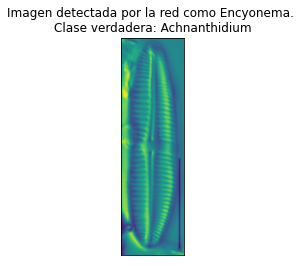

In [ ]:
random_img = misclassified_images_df.sample()
img = plt.imread(random_img.reset_index(drop=True)['filepath'].values[0])
fig = plt.imshow(img)
predicted_label = random_img.reset_index(drop=True)['predicted_label'].values[0]
real_label = random_img.reset_index(drop=True)['real_label'].values[0]
plt.title("Imagen detectada por la red como " + predicted_label + ". \nClase verdadera: " + real_label)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

# Matriz de confusión

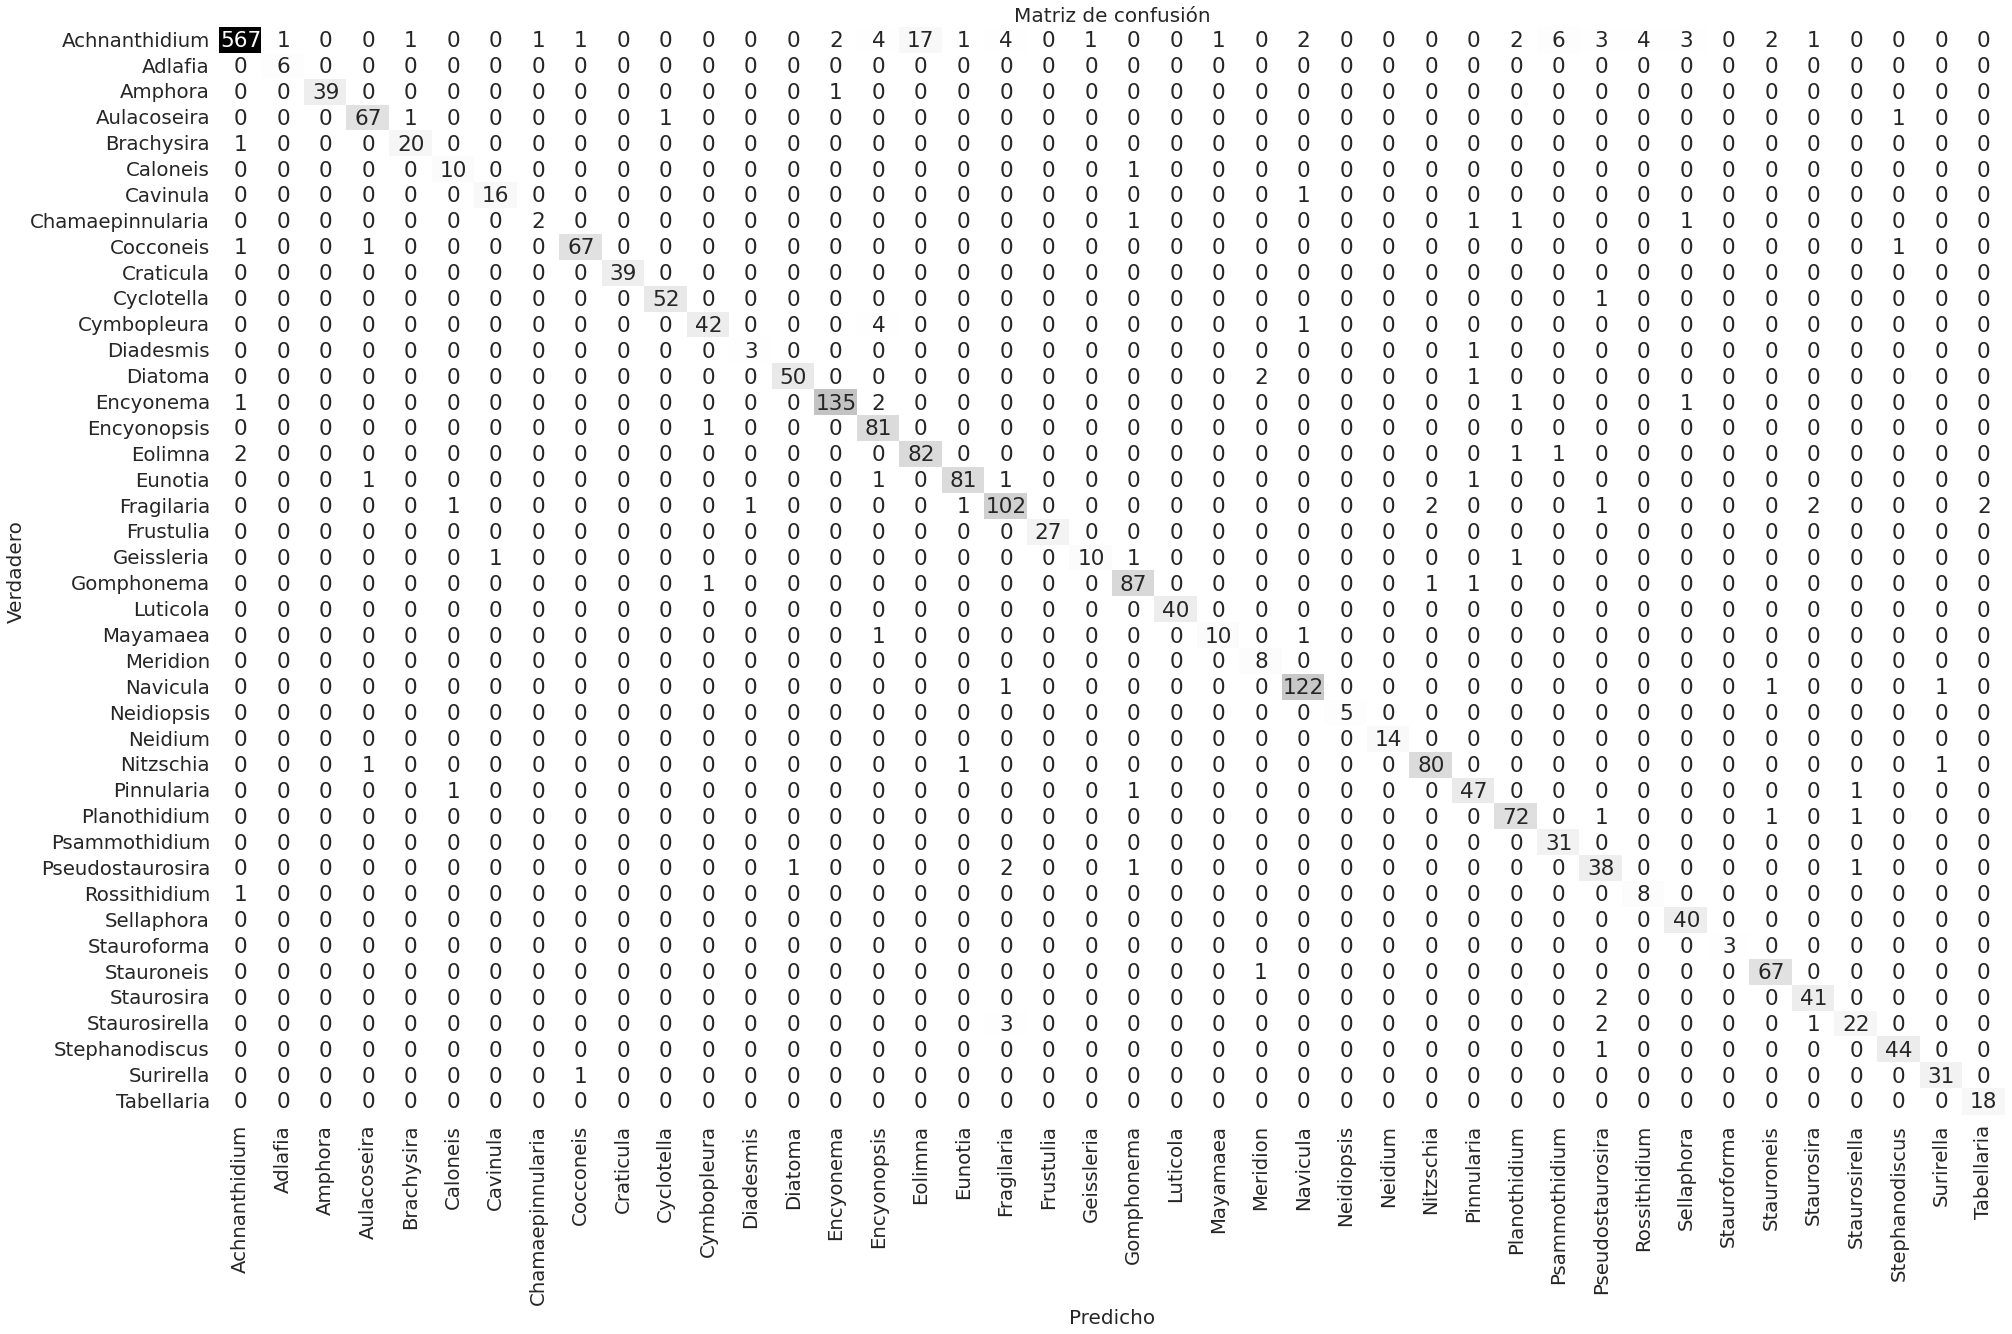

In [ ]:
ypred = np.array(y_pred)
ytrue = np.array(y_true)
cm = confusion_matrix(ytrue, ypred)

plt.figure(figsize = (32, 20))
sns.set(font_scale=1.8)
sns.heatmap(cm, annot = True, vmin = 0, fmt = 'g', cmap = 'binary', cbar = False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation = 90)
plt.yticks(np.arange(class_count)+.5, classes, rotation = 0)
plt.xlabel("Predicho", fontsize=20)
plt.ylabel("Verdadero", fontsize=20)
plt.title("Matriz de confusión", fontsize=20)
plt.show()

# Uso de la librería LIME para explicar nuestro modelo

Importamos los paquetes (no están en Colab así que hay que hacer pip para instalarlos)

In [ ]:
!pip install lime
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=684707118034029d231f8cbc7e4eaf4bebbbc6237463bf21a81ebe26453ba7b0
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


Definimos un método que carga todas las imagenes del conjunto de imágenes bien clasificadas y las procesa para que sean entradas de la red.

In [ ]:
from keras.preprocessing import image
from skimage.segmentation import mark_boundaries

def transform_img_fn():
  out = []
  for image_path in ((good_classified_images_df['filepath'])):
    img = image.load_img(image_path, target_size=img_size)
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    out.append(img_data)
  return np.vstack(out)

images = transform_img_fn()

In [ ]:
sns.set(font_scale=1.0)

A continuación mostramos varios gráficos utilizando LIME y cambiando los parámetros (hemos generado 5000 imágenes "fake" y se muestran predicciones de las 2 capas más importantes)

*   Los 5 superpíxeles más positivos en verde respecto a la clase con el resto de la imagen oculta

*   Los 5 superpíxeles más positivos respecto a la clase mostrando la imagen

*   Los 5 superpíxeles más positivos en verde y los más negativos en rojo respecto a la clase con el resto de la imagen visible

*   Mapa de calor de los píxeles midiendo su importancia.








  0%|          | 0/10000 [00:00<?, ?it/s]

[]

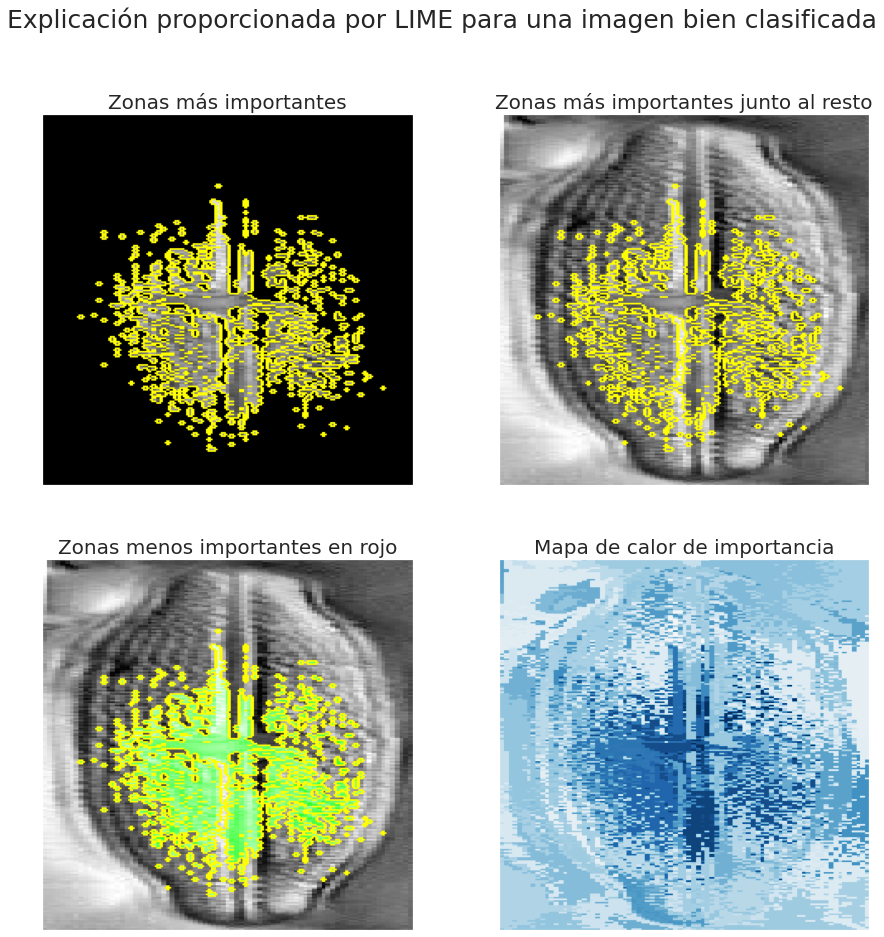

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state = 123)

explanation = explainer.explain_instance(images[random.randint(0, len(images) - 1)].astype('double'), model.predict, top_labels=2, hide_color=0, num_samples=5000)

fig, ax = plt.subplots(2,2, figsize = (15,15))
fig.suptitle('Explicación proporcionada por LIME para una imagen bien clasificada', fontsize=25)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
fig = ax[0,0].imshow(mark_boundaries(temp/255, mask))
ax[0,0].set_title("Zonas más importantes", fontsize = 20)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.grid(b=None)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
fig = ax[0,1].imshow(mark_boundaries(temp / 255, mask))
ax[0,1].set_title("Zonas más importantes junto al resto", fontsize = 20)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.grid(b=None)
plt.plot()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
fig = ax[1,0].imshow(mark_boundaries(temp / 255, mask))
ax[1,0].set_title("Zonas menos importantes en rojo", fontsize = 20)

fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.grid(b=None)
plt.plot()

# Seleccionamos la misma clase de las otras 3 explicaciones
ind =  explanation.top_labels[0]

# Cada peso de la explicación se adjunta a su píxel.
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

# Se muestran los resultados
fig = ax[1,1].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
ax[1,1].set_title("Mapa de calor de importancia", fontsize = 20)

fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.grid(b=None)
plt.plot()

# Reentrenamiento del modelo con todos los datos.
Se ha utilizado un conjunto del 20% para validación, entrenando ahora con el 80% de ellos y aplicando un balanceo de 1400 imágenes por clase. Además se ha probado a realizar aumento de datos *on the fly*, es decir, conforme se van pasando las imágenes al modelo, para darle aún más robustez. \\

No se comenta esta parte del código puesto que es una réplica del proceso de entrenamiento de modelos explicado en el archivo model_training_and_evaluation

## Carga de los datos y balanceo de clases.

In [ ]:
# Ejecución.
max_samples = 1400
min_samples = 10

sdir='/content/drive/MyDrive/data_big/'
dir = 'big'

save_dir = '/content/drive/MyDrive/saved_models/'

img_size = (224,224) 

df = get_dataframe(sdir, dir)
df, spare_df = trim(df, max_samples, min_samples)
train_df, valid_df = train_test_split(df, train_size = .8, shuffle = True, random_state = 123, stratify = df['labels']) 

print('Tamaño del conjunto de ENTRENAMIENTO: ', len(train_df))
print('Tamaño del conjunto de VALIDACIÓN: ', len(valid_df))

working_dir = r'/content/drive/MyDrive/' 
train_df = balance(train_df, max_samples, min_samples, working_dir, img_size, 0)

print('Tamaño del conjunto de ENTRENAMIENTO ACTUALIZADO: ', len(train_df))

print("Dataframe train final:")
classes = list(train_df['labels'].unique())
class_count = len(classes)
groups = train_df.groupby('labels')

print('{0:^30s} {1:^13s}'.format('Clase', 'Número de imágenes'))
for label in train_df['labels'].unique():
      group = groups.get_group(label)      
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

El archivo  /content/drive/MyDrive/data_big/Achnanthidium/Achnanthidium_eutrophilum (1).db  es una imagen inválida. 
El df tiene  44  clases.
            Clase              Cantidad de imágenes
          Craticula                 195     
           Amphora                  200     
           Adlafia                  28      
           Cavinula                 84      
           Caloneis                 54      
        Achnanthidium              1424     
          Brachysira                104     
         Aulacoseira                351     
       Chamaepinnularia             31      
          Cocconeis                 348     
           Diatoma                  267     
         Encyonopsis                409     
          Cyclotella                263     
          Frustulia                 136     
         Cymbopleura                233     
           Eunotia                  426     
          Encyonema                 701     
          Diadesmis                 21   

## Entrenamiento del modelo

In [ ]:
# Modelo
lr = .001 
dropout = 0.0
img_shape = (img_size[0], img_size[1], 3)
batch_size = 16
epochs = 40
ask_epoch = 40
pooling = "avg"
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
save_dir = '/content/drive/MyDrive/saved_models/'

t_and_v_gen = ImageDataGenerator()
trgen = ImageDataGenerator(rotation_range = 180, width_shift_range = .2, height_shift_range = .2, zoom_range = .1, horizontal_flip=True, vertical_flip = True, brightness_range=[0.7,1.3])

train_gen = t_and_v_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size,
                                    class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size,
                                    class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)


model_name = 'EfficientNetV2B0_retrain'
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights="imagenet",input_shape=img_shape, pooling=pooling) 

base_model.trainable = True

x = base_model.output

output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

model_name = save_dir + model_name + "_lr_" + str(lr) + "_bs_" + str(batch_size) + "_pooling_" + pooling + "_samples_" + str(max_samples) + ".h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name, 
          monitor='val_accuracy', verbose=1, 
          save_best_only=True, mode='max')
rlronp = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2, verbose = 1)
estop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 6, verbose = 1, restore_best_weights = True)
ask = ASK(model, epochs,  ask_epoch)

callbacks = [rlronp, estop, checkpoint, ask]

history = model.fit(x = train_gen,  epochs = epochs, verbose = 1, callbacks = callbacks,  validation_data = valid_gen)

Found 58800 validated image filenames belonging to 42 classes.
Found 2124 validated image filenames belonging to 42 classes.
El entrenamiento seguirá hasta la época 40 . Posteriormente se le le pedirá
 escribir H para parar o volver a insertar un número de épocas para seguir entrenando.
Epoch 1/40
3675/3675 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.8357
Epoch 1: val_accuracy improved from -inf to 0.85782, saving model to /content/drive/MyDrive/saved_models/EfficientNetV2B0_retrain_lr_0.001_bs_16_pooling_avg_samples_1400.h5
3675/3675 [==============================] - 286s 75ms/step - loss: 0.5551 - accuracy: 0.8357 - val_loss: 0.4868 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 2/40
3675/3675 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9350
Epoch 2: val_accuracy improved from 0.85782 to 0.89454, saving model to /content/drive/MyDrive/saved_models/EfficientNetV2B0_retrain_lr_0.001_bs_16_pooling_avg_samples_1400.h5
3675/3675 [=======

## Visualización de la evaluación del modelo en el entrenamiento

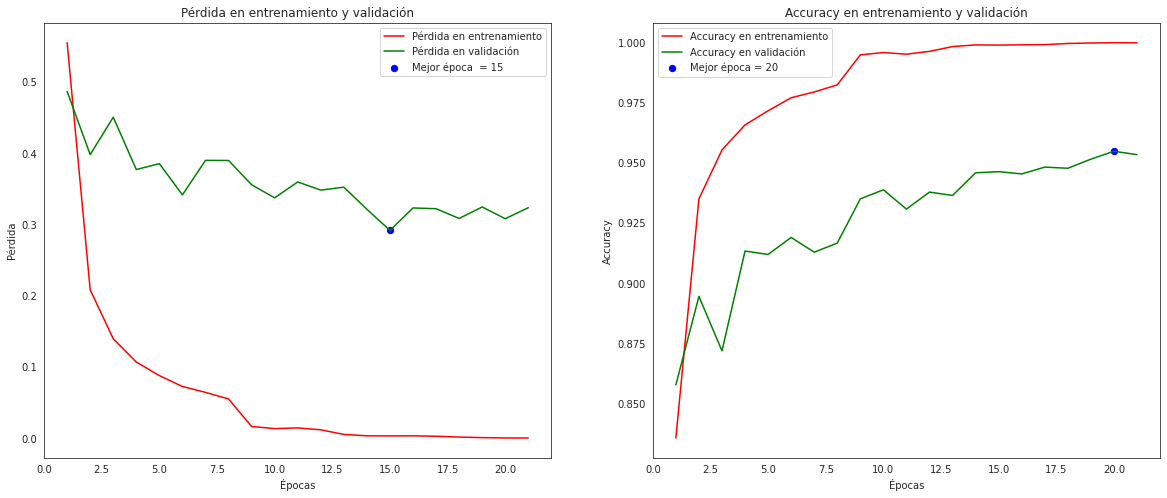

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []

    sns.set_style("white")
    
    for i in range (start_epoch, Epoch_count):
        Epochs.append(i+1)   
        
    index_loss = np.argmin(vloss) #  Época con menor error de validación.
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    sc_label = 'Mejor época  = '+ str(index_loss + 1 + start_epoch)
    vc_label = 'Mejor época = '+ str(index_acc + 1 + start_epoch)
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
    
    
    axes[0].plot(Epochs,tloss, 'r', label = 'Pérdida en entrenamiento')
    axes[0].plot(Epochs,vloss,'g', label = 'Pérdida en validación' )
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s = 40, c = 'blue', label = sc_label)
    axes[0].set_title('Pérdida en entrenamiento y validación')
    axes[0].set_xlabel('Épocas')
    axes[0].set_ylabel('Pérdida')
    axes[0].legend()
    axes[1].plot (Epochs, tacc, 'r', label = 'Accuracy en entrenamiento')
    axes[1].plot (Epochs, vacc, 'g', label = 'Accuracy en validación')
    axes[1].scatter(index_acc + 1 + start_epoch,  acc_highest, s = 40, c = 'blue', label = vc_label)
    axes[1].set_title('Accuracy en entrenamiento y validación')
    axes[1].set_xlabel('Épocas')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)